# Проект "Прогнозирование вероятности оттока пользователей для фитнес-центров"

1. [Описание проекта](#desc)
2. [Изучение общей информации](#info)
3. [Исследовательский анализ данных](#eda)
4. [Построение модели прогнозирования оттока клиентов](#forecast)
5. [Кластеризация клиентов](#clast)
6. [Общий вывод](#concl)

<a id="desc"></a> 
## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Цель исследования** — провести анализ и подготовить план действий по удержанию клиентов.

**Задачи исследования**:

1) Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;\
2) Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;\
3) Проанализировать основные признаки, наиболее сильно влияющие на отток;\
4) Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
* выделить целевые группы клиентов;
* предложить меры по снижению оттока;
* определить другие особенности взаимодействия с клиентами.


<a id="info"></a> 
## Изучение общей информации

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Итак, в таблице 4000 строк, 14 колонок.
Набор данных включает следующие поля:
1) Данные клиента за предыдущий до проверки факта оттока месяц:
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

2) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.


Посмотрим, какие значения есть в колонках.

In [6]:
for column in data.columns:
    print(column)
    print(data[column].unique())

gender
[1 0]
Near_Location
[1 0]
Partner
[1 0]
Promo_friends
[1 0]
Phone
[0 1]
Contract_period
[ 6 12  1]
Group_visits
[1 0]
Age
[29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
Avg_additional_charges_total
[ 14.22747042 113.20293765 129.44847933 ...  78.25054157  61.91265691
 178.86181361]
Month_to_end_contract
[ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
Lifetime
[ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
Avg_class_frequency_total
[0.02039795 1.92293606 1.85909835 ... 2.78614636 1.63010814 1.10183221]
Avg_class_frequency_current_month
[0.         1.91024352 1.73650189 ... 2.8314395  1.59623664 1.03526976]
Churn
[0 1]


На первый взгляд все хорошо.

**Вывод**

Итак, в каждой строке у нас есть информация о клиенте, его личных данных, а также информация из журнала его посещений. Какие есть проблемы в данных?

- Сразу бросается в глаза, что имена колонок написаны не в "змеином регистре", надо это исправить. Пропусков в данных нет, и это отлично. Все признаки численные.
- Посмотрим на средние значения и стандартные отклонения в данных.
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).
- Построим матрицу корреляций и визуализируем ее.

<a id="eda"></a> 
## Исследовательский анализ данных

Для начала переименуем колонки.

In [7]:
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

**Изучим средние значения и стандартные отклонения.**

In [8]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Видно, что в данных есть как категориальные, так и количественные данные. Примерно 27 % клиентов ушли в отток. Такая доля оттока говорит о дисбалансе классов в целевом признаке. Если судить по **std**, есть достаточно большой разброс данных в признаке **avg_additional_charges_total**. Надо построить графики для более детального изучения распределения признаков. 

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.**

In [9]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


**Вывод**

В обеих группах примерно наполовину распределено количество мужчин и женщин. Среди тех, кто остался большее количество людей, пользующихся специальными бонусными программами, посещающих групповые занятия, по сравнению с пользователями, которые уши. Также в группе, кто остался, пользователи заключают контракт на большее количество месяцев. И у них большее, в среднем, количество посещений в неделю. Если у тех, кто остался, средний лайфтайм - около 5 месяцев, то у тех, кто ушел - около 1 месяца. ТО есть те люди, которые ушли, не прозанимались и 1-2 месяцев.

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).**

Сначала сделаем 2 отдельные таблицы: с клиентами, которые ушли и которые остались.

In [10]:
data_churn_0 = data.query('churn == 0')

In [11]:
data_churn_1 = data.query('churn == 1')

**РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ ДЛЯ КЛИЕНТОВ, КОТОРЫЕ ОСТАЛИСЬ.**

Построим сначала столбчатые графики для категорий.

In [12]:
category_list = ['gender', 'age', 'near_location', 'partner', 'promo_friends', 'phone', 'lifetime', 'contract_period', 'month_to_end_contract','group_visits']

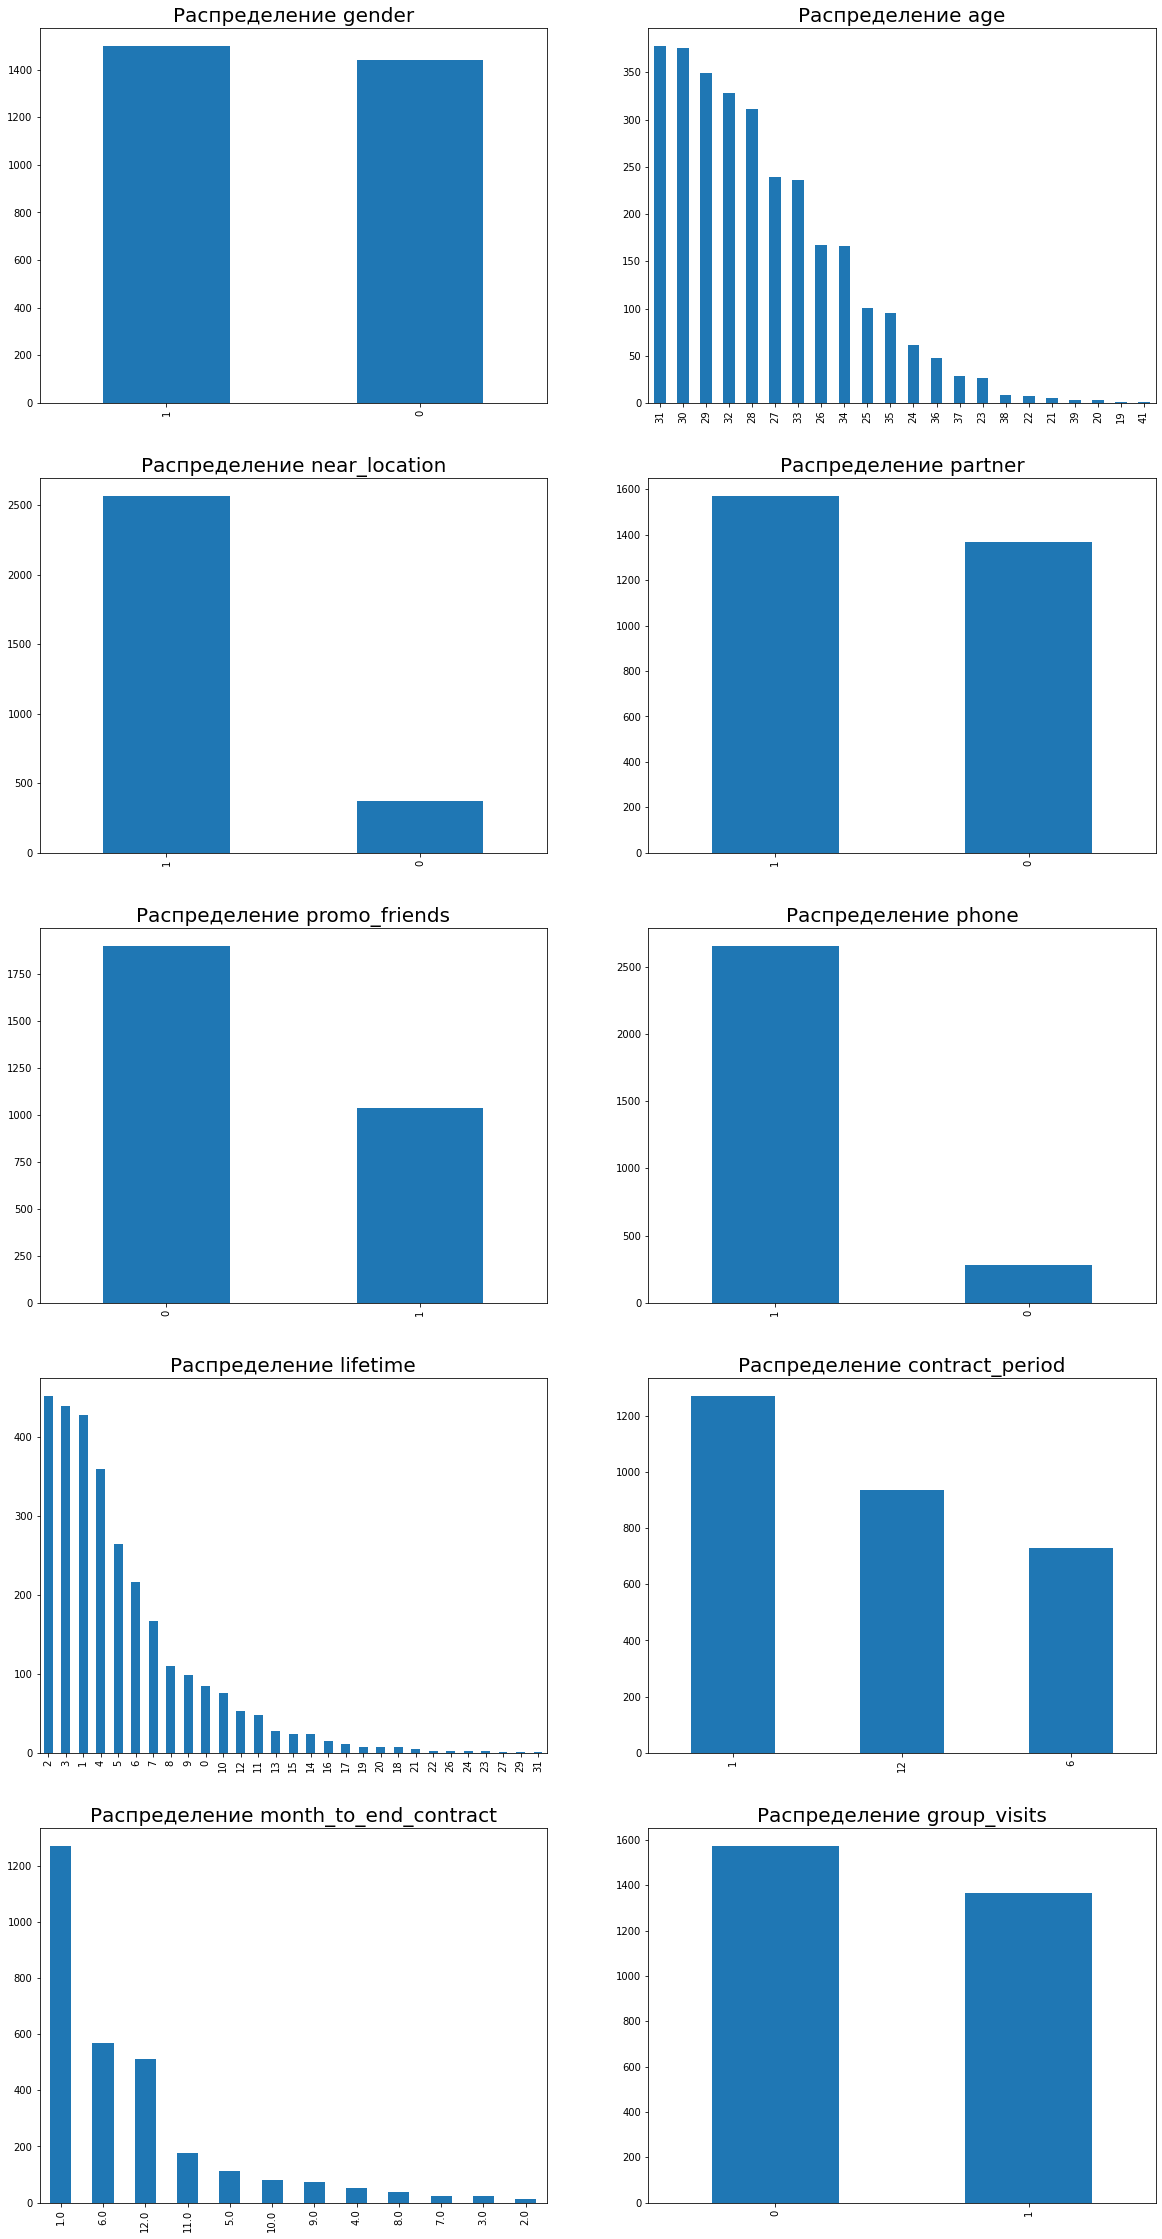

In [13]:
plt.figure(figsize=(20,40))
for i, column in enumerate(category_list):
    data_churn_0[column].value_counts().plot.bar(ax=plt.subplot(5,2,i+1))
    plt.title('Распределение {}'.format(column),fontsize=20);

**Вывод**

По графикам видно:
-  Количество мужчин и женщин примерно одинаково;
-  Средний возраст посетителей - около 30 лет.
-  Большинство посетителей проживают или работают недалеко от фитнес-центра;
-  Статус "партнер" имеет чуть больше половины посетителей;
-  Почти 2/3 посетителей использовали при первом посещении промокод "promo-friends";
-  Практически все посетители оставили в базе данных центра свой телефон;
-  Самое распространенное значение "lifetime" - от 0 до 7
-  У клиентов наибольшим спросом пользуется контракт на 1 месяц, затем на 12, и в меньшей степени на 6 месяцев;
-  У большей части клиентов до конца действия контракта остался 1 месяц;
-  Групповые занятия посещает чуть меньше половины клиентов.

Построим гистограммы для остальных признаков.

In [14]:
num_list = ['avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']

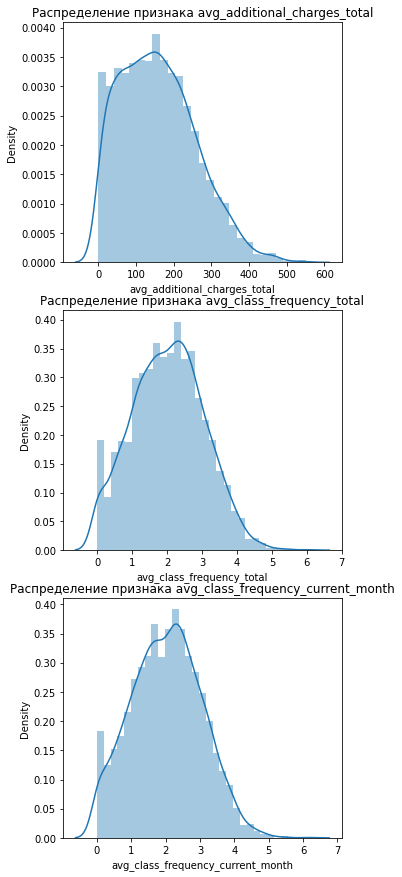

In [15]:
plt.figure(figsize=(5,15))
for i, column in enumerate(num_list):
    sns.distplot(data_churn_0[column], ax=plt.subplot(3,1,i+1))
    #data_churn_0[column].value_counts().plot.bar(ax=plt.subplot(3,4,i+1))
    plt.title('Распределение признака {}'.format(column),fontsize=12);

**Вывод**

Все три распределения смещены вправо, так как есть выбросы. 

**РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ ДЛЯ КЛИЕНТОВ, КОТОРЫЕ УШЛИ.**

Построим столбчатые графики для категорий.

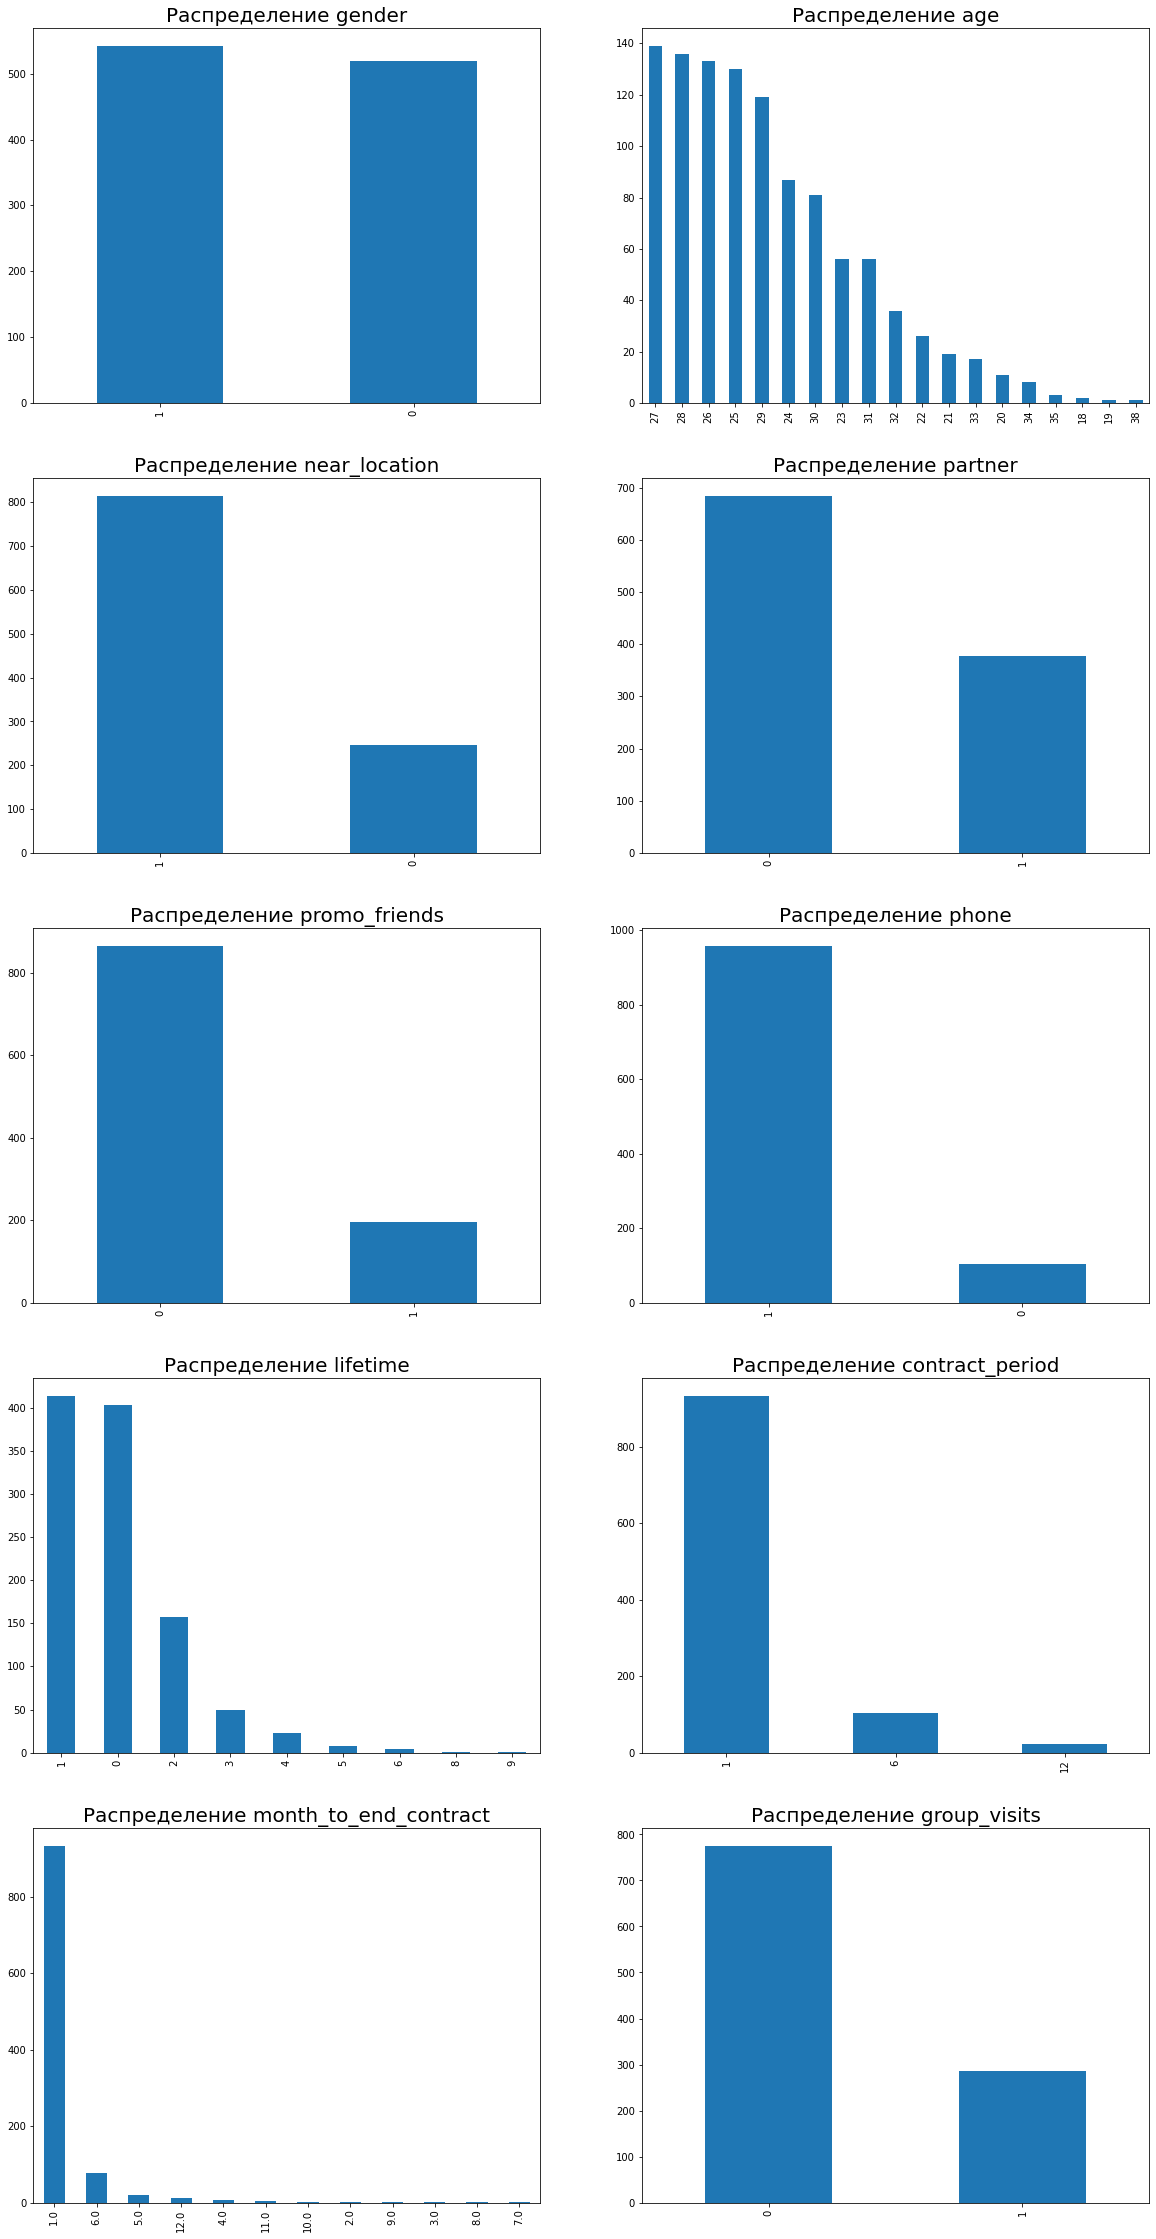

In [16]:
plt.figure(figsize=(20,40))
for i, column in enumerate(category_list):
    data_churn_1[column].value_counts().plot.bar(ax=plt.subplot(5,2,i+1))
    plt.title('Распределение {}'.format(column),fontsize=20);

**Вывод**

- Большинство признаков схожи с первой группой (посетители, которые остались), но есть и отличия, такие как:
- Средний возраст посетителей чуть ниже по сравнению с первой группой - около 27 лет;
- У клиентов наибольшим спросом пользуется контракт на 1 месяц, затем на 6, и в меньшей степени на 12 месяцев;
- Основная масса посетитилей в этой группе имеет лайфтайм **0** и **1**;

Построим гистограммы для остальных признаков.

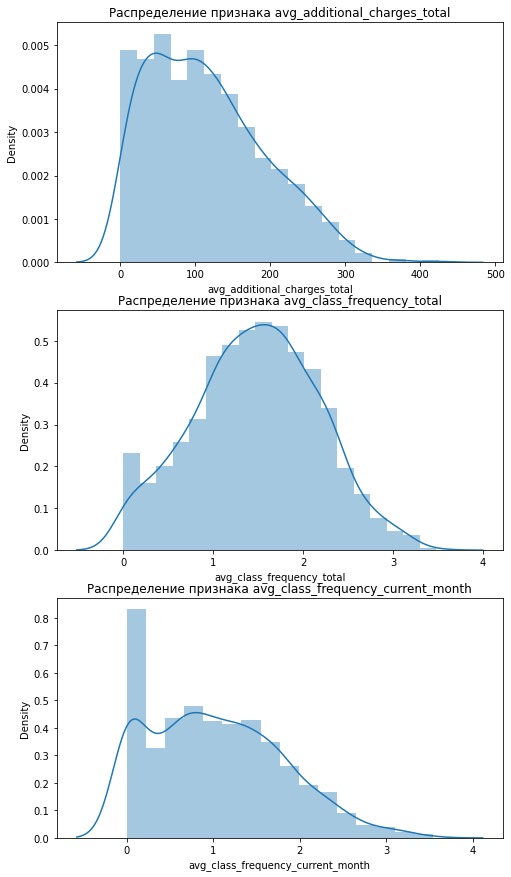

In [17]:
plt.figure(figsize=(8,15))
for i, column in enumerate(num_list):
    sns.distplot(data_churn_1[column], ax=plt.subplot(3,1,i+1))
    plt.title('Распределение признака {}'.format(column),fontsize=12);

**Вывод**

- График с признаков **avg_additional_charges_total**  скошен вправо, есть небольшой хвост с выбросами.
- График с признаком **avg_class_frequency_total** похож на нормальное распределение.
- У графика с признаком **avg_class_frequency_current_month** есть всплеск около значения **0**. И небольшой хвост (т.е. есть выбросы).

Думаю, надо удалить выбросы, чтобы при дальнейшем построении модели они не исказили выводы. Построим точечные графики 3 признаков, в которых есть выбросы по общей таблице, чтобы решить какие значения можно безболезненно удалить.

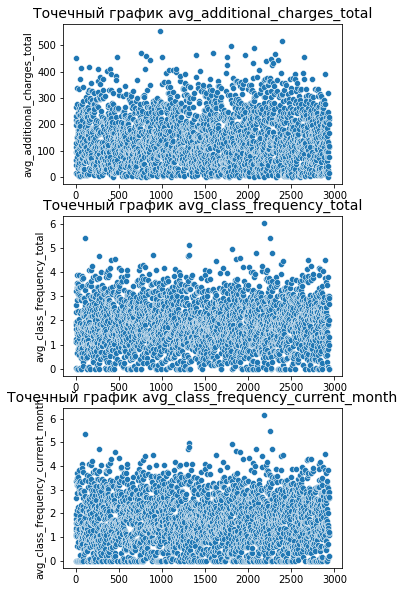

In [18]:
# Построим точечные графики 
plt.figure(figsize=(5,10))
for i, column in enumerate(num_list):
    values = pd.Series(range(0, len(data_churn_0)))
    sns.scatterplot(values, data[column], ax=plt.subplot(3,1,i+1));
    plt.title('Точечный график {}'.format(column),fontsize=14);

По графикам также видим единичные выбросы. Посмотрим на 95 и 91 прецентиль у этих 3 признаков.

In [19]:
for column in num_list:
    print(column)
    print(np.percentile(data[column], [95, 99]))

avg_additional_charges_total
[323.44087589 400.99612505]
avg_class_frequency_total
[3.53564837 4.19757925]
avg_class_frequency_current_month
[3.54906154 4.18575779]


Видим, что не более 1 % клиентов совершили покупки в фитнес-центре больше 400,99, а также совершают в среднем свыше 4,19 посещений в неделю в целом и свыше 4,18 посещений за текущий месяц. Удалим таких пользователей.

In [20]:
charges_lim = np.percentile(data['avg_additional_charges_total'], 99)
avg_freq_total_lim = np.percentile(data['avg_class_frequency_total'], 99)
avg_freq_month_lim = np.percentile(data['avg_class_frequency_current_month'], 99)

data = data.query('avg_additional_charges_total < @charges_lim\
                  and avg_class_frequency_total < @avg_freq_total_lim\
                  and avg_class_frequency_current_month < @avg_freq_month_lim')

In [21]:
data.shape

(3917, 14)

**Вывод**

Итак, у нас осталось 3917 строк из 4000. Мы лишились около 2% строк. 

**Построим матрицу корреляций и отобразим её.**

In [22]:
cm = data.corr()

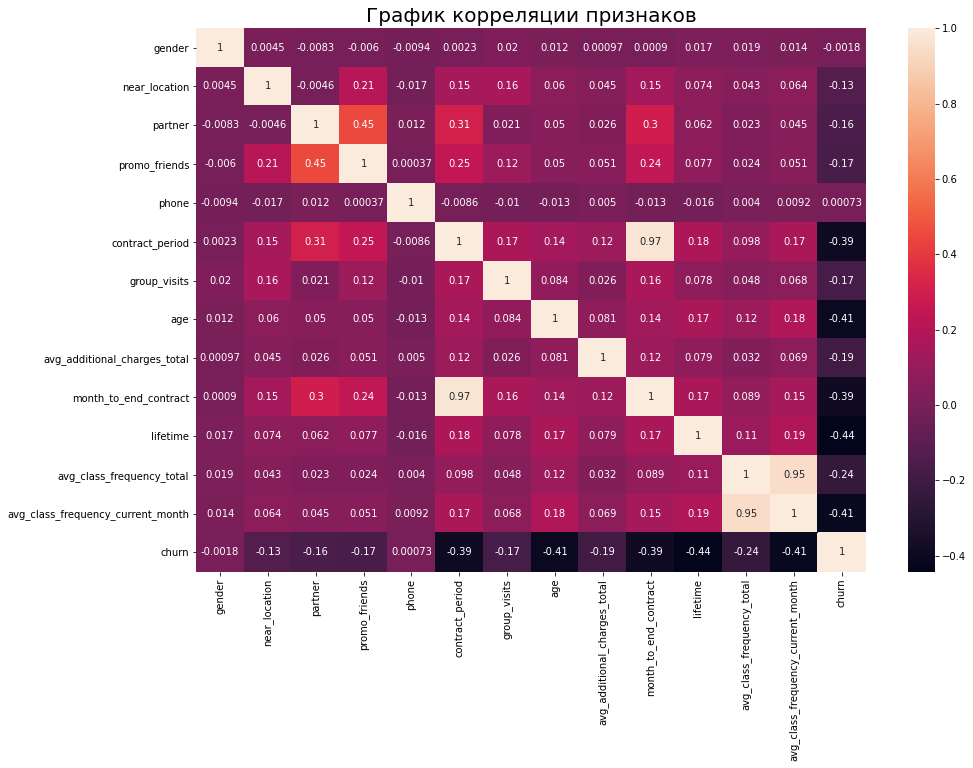

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True)
plt.title('График корреляции признаков', fontsize=20);

**Вывод**

С целевой переменной ни один из признаков сильно не коррелирует. Есть 2 пары признаков, которые коррелируют друг с другом достаточно сильно:
- contract_period и month_to_end_contract;
- avg_class_frequency_total и avg_class_frequency_current_month.
Остальные признаки друг с другом не особо коррелируют.
Думаю надо удалить те признаки, которые сильно коррелируют с другими, так как мультиколлинеарность может привести к переобучению и неустойчивости модели.

In [24]:
# удалим столбцы "month_to_end_contract" и "avg_class_frequency_current_month"
rest = data.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1)

In [25]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3917 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        3917 non-null   int64  
 1   near_location                 3917 non-null   int64  
 2   partner                       3917 non-null   int64  
 3   promo_friends                 3917 non-null   int64  
 4   phone                         3917 non-null   int64  
 5   contract_period               3917 non-null   int64  
 6   group_visits                  3917 non-null   int64  
 7   age                           3917 non-null   int64  
 8   avg_additional_charges_total  3917 non-null   float64
 9   lifetime                      3917 non-null   int64  
 10  avg_class_frequency_total     3917 non-null   float64
 11  churn                         3917 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 397.8 KB


<a id="forecast"></a> 
## Построим модель прогнозирования оттока клиентов

Итак, нам надо построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [26]:
# разделим данные на признаки и целевую переменную
X = rest.drop('churn', axis=1)
y = rest['churn']

In [27]:
# разобьем данные на обучающую и валидационную выборку в отношении 80:20 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

In [28]:
# обучим модель (логистическая регрессия) и сделаем прогнозы
model = LogisticRegression(random_state=0, solver='liblinear') 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [29]:
# обучим модель (случайный лес) и сделаем прогнозы
rf_model = RandomForestClassifier(random_state=0) 
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

In [30]:
print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('')
print('Метрики для случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))


Метрики для логистической регрессии
Accuracy: 0.89
Precision: 0.80
Recall: 0.81

Метрики для случайного леса
Accuracy: 0.91
Precision: 0.84
Recall: 0.82


**Вывод**

Обе наши модели предсказывают около 90% правильных ответов. Две остальные метрики в обоих случаях неплохие. Но случайный лес справился немного лучше.

<a id="clast"></a> 
## Сделаем кластеризацию клиентов

In [31]:
# стандартизуем признаки
sc = StandardScaler()
x_sc = sc.fit_transform(X)

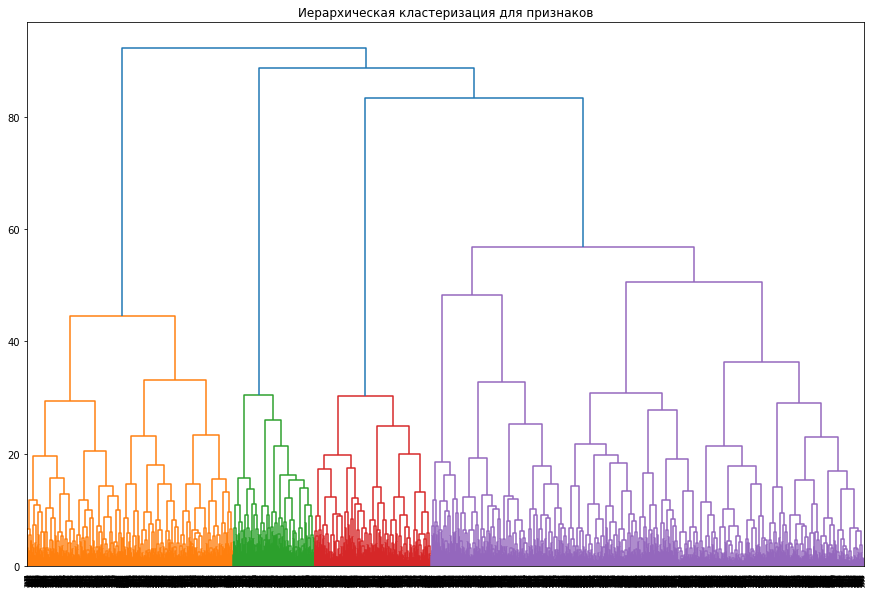

In [32]:
# построим матрицу расстояний на стандартизованной матрице признаков 
linked = linkage(x_sc, method='ward')

# нарисуем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для признаков');

**Вывод**

Итак, предложенное оптимальное число кластеров - 4. Но согласно договоренности по проекту, в дальнейшем будем использовать число кластеров равное 5.

In [33]:
# обучим модель кластеризации и спрогнозируем кластеры клиентов (возьмем число 5)
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(x_sc)

In [34]:
rest['cluster'] = labels

**Посмотрим на средние значения признаков для кластеров.**

In [35]:
rest.drop('churn', axis=1).groupby('cluster').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total
cluster,,,,,,,,,,,
0,0.50,0.00,0.49,0.08,1.00,3.00,0.23,28.69,133.90,3.01,1.74
1,0.54,1.00,0.25,0.08,1.00,4.50,1.00,29.55,143.65,3.76,1.91
2,0.49,1.00,0.96,0.89,1.00,7.67,0.45,29.53,152.62,4.39,1.93
3,0.51,1.00,0.24,0.06,1.00,2.82,0.00,28.75,140.58,3.33,1.78
4,0.53,0.86,0.47,0.31,0.00,4.79,0.42,29.30,142.23,3.90,1.84


Видим, что некоторые кластеры имеют признаки, в которых только **0** или только **1**. 
- Кластер **0**. Все пользователи живут далеко от фитнес-центра(среднее значение признака **near_location** - 0). У этого кластера почти 50 % клиентов имеют бонус **partner**(этим и можно объяснить, почему живя далеко, они все таки посещают именно этот фитнес-центр). 
- Кластер **1**. Судя по среднем значению признака **group_visits**, все посетители этого кластера посещают групповые занятия.
- Кластер **2**.В этом кластере очень большая доля пользователей имеет бонусы **PARTNER** и **PROMO_FRIENDS**. Также у пользователей этого кластера максимальное (по сравнению с другими) среднее количество месяцев заключенного контракта. Еще пользователи 2 кластера тратят чуть больше, чем другие, на дополнительные услуги фитнес-центра и у них чуть выше средний лайфтайм. 
- Кластер **3**. Основной отличительной особенностью является то, что все клиенты этого кластера НЕ посещают групповые занятия.
- Кластер **4**. Основная особенность - клиенты этого кластера не оставили свой контактный телефон.
Построим распределения признаков для кластеров

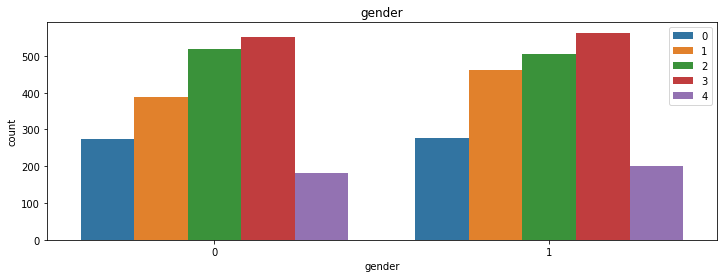

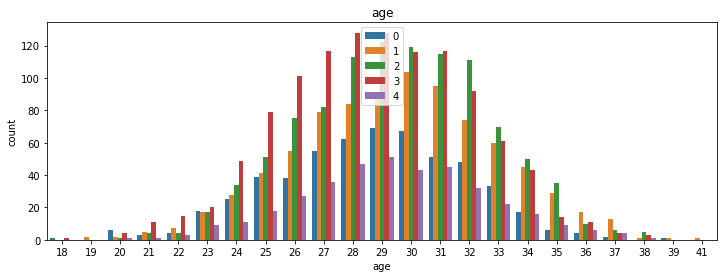

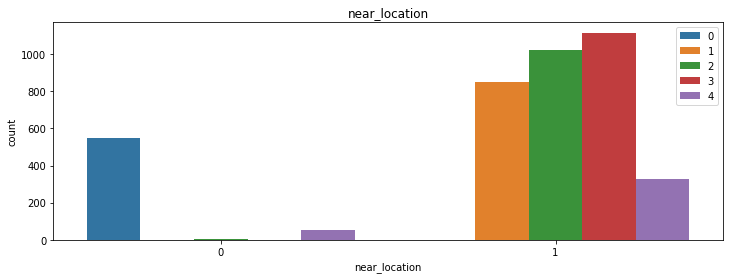

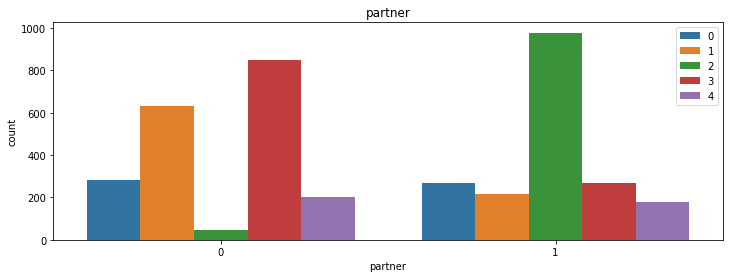

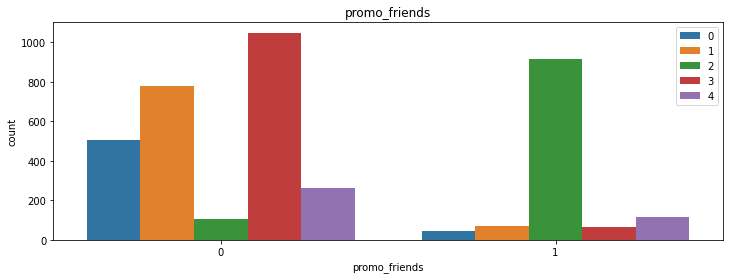

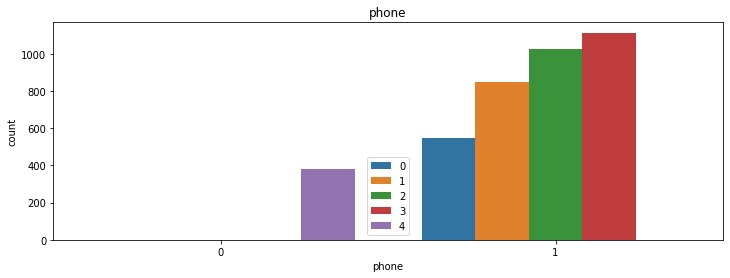

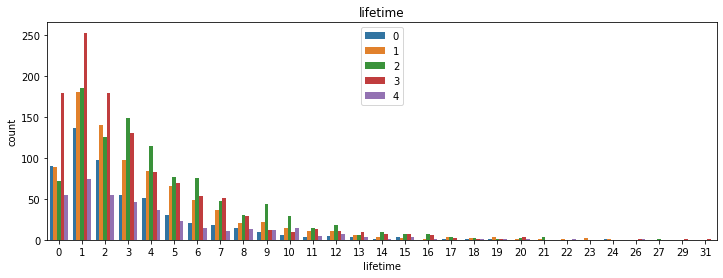

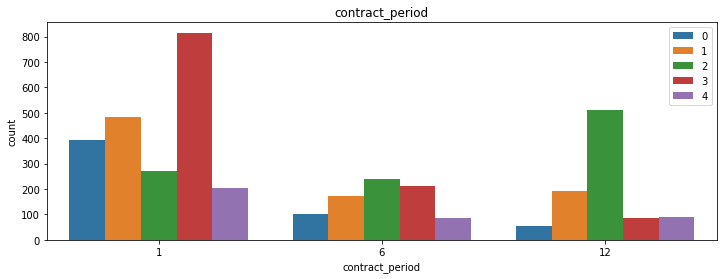

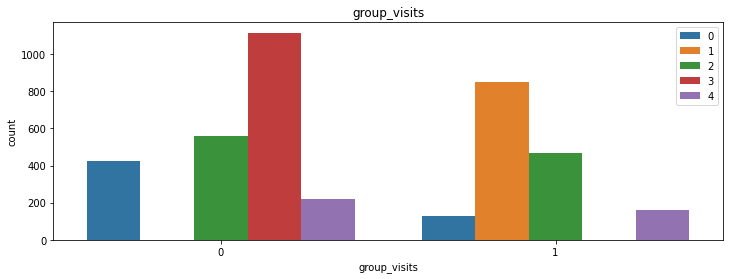

In [36]:
# Построим графики распределения для категориальных признаков
categorical_columns = ['gender', 'age', 'near_location', 'partner', 'promo_friends', 'phone', 'lifetime', 'contract_period','group_visits']
for column in categorical_columns:
    plt.figure(figsize=(12, 4))
    sns.countplot(x = rest[column], hue='cluster', data=rest)
    plt.title(column)
    plt.legend()
    plt.show()

<Figure size 360x216 with 0 Axes>

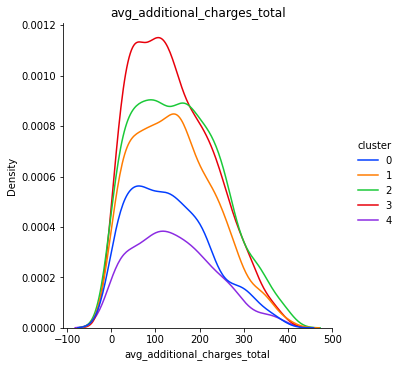

<Figure size 360x216 with 0 Axes>

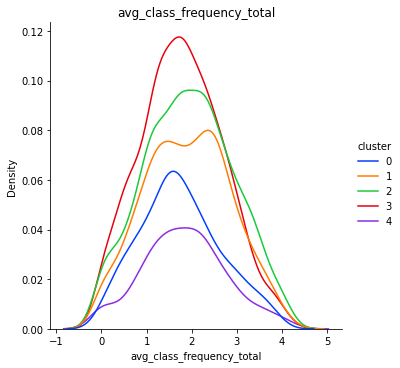

In [37]:
# Построим графики распределения для числовых признаков
num_columns = ['avg_additional_charges_total','avg_class_frequency_total']
    
for column in num_columns:
    plt.figure(figsize=(5, 3))
    sns.displot(x = rest[column], hue='cluster', data=rest, kind='kde', palette='bright')
    plt.title(column)
    plt.show();


**Вывод**

Итак, графики только подтвердили предыдущие выводы:
- В кластере **0** все пользователи НЕ проживают или работают вблизи от фитнес-центра. Тогда как в кластерах **1,2,3** пользователи проживают или работают рядом с фитнес-центром.
- Больше всего пользователей, пользующихся бонусам **Partner** и **Promo-Friends** у кластера **2**, меньше всего этими бонусами пользуются клиенты **3** кластера.
- В кластере **4** пользователи, которые не оставили телефоны. 
- Контракт на 1 месяц чаще заключают клиенты из кластера **3**, а на 12 месяцев - кластер **2**.
- В кластере **1** - все пользователи посещают групповые занятия, в в кластере **3**, напротив, никто такие занятия не посещает.
- Больше остальных на дополнительные услуги тратят клиенты из кластера **3**, меньше всех - из кластера **4**.
- Средняя частота посещений в неделю у всех кластеров 2 раза.
Остальные признаки у кластеров более-менее похожи.

**Посчитаем долю оттока для каждого полученного кластера.**

In [38]:
rest.groupby('cluster')[['churn']].mean().sort_values('churn', ascending=False)

,churn
cluster,
0,0.41
3,0.39
4,0.27
1,0.21
2,0.12


**Вывод**

По таблице видно, что кластеры различаются по доле оттока. Так, кластеры **0** и **3** наиболее подвержены оттоку. ТОгда как кластер **2** более надежен.

<a id="concl"></a> 
## Общий вывод

Итак, изучив таблицу клиентов, я пришла к выводу, что в некоторых колонках(признаках) есть выбросы. Поскольку выбросов было не так много, пришла к выводу, что от них можно избавиться. Затем был проведен анализ и построена модель прогнозирования оттока клиентов (на уровне следующего месяца), которая дает более 90% правильных ответов.\
Также было выделено несколько наиболее типичных групп клиентов и выделены наиболее яркие их черты:
- Группа **0**. Все пользователи живут далеко от фитнес-центра(среднее значение признака **near_location** - 0). У этого кластера почти 50 % клиентов имеют бонус **partner**(этим и можно объяснить, почему живя далеко, они все таки посещают именно этот фитнес-центр). 
- Группа **1**. Судя по среднем значению признака **group_visits**, все посетители этого кластера посещают групповые занятия.
- Группа **2**.В этом кластере очень большая доля пользователей имеет бонусы **PARTNER** и **PROMO_FRIENDS**. Также у пользователей этого кластера максимальное (по сравнению с другими) среднее количество месяцев заключенного контракта. Еще пользователи 2 кластера тратят чуть больше, чем другие, на дополнительные услуги фитнес-центра и у них чуть выше средний лайфтайм. 
- Группа **3**. Основной отличительной особенностью является то, что все клиенты этого кластера НЕ посещают групповые занятия.
- Группа **4**. Основная особенность - клиенты этого кластера не оставили свой контактный телефон.
Проанализировав эти группы, я пришла к выводу, что наиболее склонны к оттоку группы **0** и **3**. Самая надежная группа, где доля оттока составляет всего
12% - это группа **2**.

**РЕКОМЕНДАЦИИ**

1) В группе с наименьшим оттоком есть большая доля клиентов с бонусам **Partner** и **Promo-friends**. Возможно стоит и дальше развивать тему различных бонусов, например, скидка в день рождения и т.д.\
2) Самая склонная к оттоку группа **0** - пользователи этой группы живут далеко от фитнес-центра. Поэтому, возможно, для того, чтобы снизить долю оттока для этой категории, стоит давать дополнительные бонусы и скидки. Например, найти партнера-компанию перевозчика(такси), которые сделают скидку для наших клиентов.\
3) Также мы видим, что в группах с меньшей долей оттока достаточно большая доля клиентов, посещающих групповые занятия. Надо развивать эту тему. Возможно, стоит подумать над тем, чтобы сделать для клиентов с детьми более удобные условия, например, детские комнаты. Или нанять детского инструктора, когда родители занимаются, то тут же рядом, занимаются их дети. Не у всех родителей есть возможность оставить детей с кем-то, и думаю, это было бы неплохим решением для привлечения семей с детьми в наш фитнес-центр.\
4) Также есть идея проанализировать еще и время посещения фитнес-центра. Есть часы-пик, когда много людей, а есть не очень популярные часы. Может быть, стоит подумать над тем, чтобы стимулировать людей посещать центр в менее популярное время, сделать скидку, акцию. И тем самым разгрузить часы пик.
5) У кластеров с самым высоким оттоком средняя длительность текущего абонемента заметно ниже, чем у остальных. Можно продумать акционные предложения для абонементов на более длительный срок.
